In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn import metrics
import warnings

In [106]:
# 타이타닉 데이터 전처리
df_t = sns.load_dataset('titanic')

# 불필요 컬럼 제거
df_t.drop(columns=['class', 'alive', 'embark_town', 'who', 'adult_male', 'alone'], inplace=True)

# 연령의 결측치 해결
age_md = df_t.groupby(['pclass', 'sex']).age.agg(['median'])
df_t.loc[(df_t['sex'] == 'male') & (df_t['pclass'] == 1) & (df_t.age.isna()), "age"] = age_md.loc[1, 'male'][0]
df_t.loc[(df_t['sex'] == 'male') & (df_t['pclass'] == 2) & (df_t.age.isna()), "age"] = age_md.loc[2, 'male'][0]
df_t.loc[(df_t['sex'] == 'male') & (df_t['pclass'] == 3) & (df_t.age.isna()), "age"] = age_md.loc[3, 'male'][0]
df_t.loc[(df_t['sex'] == 'female') & (df_t['pclass'] == 1) & (df_t.age.isna()), "age"] = age_md.loc[1, 'female'][0]
df_t.loc[(df_t['sex'] == 'female') & (df_t['pclass'] == 2) & (df_t.age.isna()), "age"] = age_md.loc[2, 'female'][0]
df_t.loc[(df_t['sex'] == 'female') & (df_t['pclass'] == 3) & (df_t.age.isna()), "age"] = age_md.loc[3, 'female'][0]

# embarked 결측치 해결
df_t.embarked.fillna(df_t.embarked.unique()[0], inplace=True)

# 연령층 별 컬럼 생성.
df_t.loc[df_t.age >= 50, "age_new"] = "old"
df_t.loc[(df_t.age < 50) & (df_t.age>=10), "age_new"] = "young"
df_t.loc[df_t.age < 10, "age_new"] = "baby"

# 인코딩
# for column in ['sex', 'embarked', 'age_new'] :
#     datas = df_t[column].unique()
#     for i, d in enumerate(datas) :
#         df_t[column].replace(d, i, inplace=True)

# 인코딩
og_columns = df_t.columns[(df_t.dtypes=='O')|(df_t.dtypes=='category')|(df_t.dtypes=='bool')]            
for i in og_columns :
    globals()[f'df1_{i}_encoder'] = LabelEncoder()
    globals()[f'df1_{i}_encoder'].fit(df_t[i])
    df_t[i] = globals()[f'df1_{i}_encoder'].transform(df_t[i])




# X, Y 분리
X = df_t.drop(columns='survived')
y = df_t['survived']

# test, train 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

# np.random.shuffle
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000) #ccp : 분기점
rfc.fit(X_train, y_train)
# predict이 필요한 이유 : 정답이 없는 경우가 있기 때문.
dt_pred = rfc.predict(X_test)


# 새로운 타이타닉 데이터 전처리 

df_test = pd.read_csv('./test.csv')

# df_test.info()
# Name, Sex, Ticket, Cabin, Embarked 해결 필요

# 연령의 결측치 해결
# fare 결측치 해결
age_md = df_test.groupby(['Pclass', 'Sex']).Age.agg(['median'])
fare_md = df_test.groupby(['Pclass', 'Sex']).Fare.agg(['median'])
for i in ['male', 'female'] : 
    for y in range(1, 4) : 
        f"df_test.loc[(df_test['Sex'] == '{i}') & (df_test['Pclass'] == {y}) & (df_test.Age.isna()), 'Age'] = age_md.loc[{y}, '{i}'][0]"
        f"df_test.loc[(df_test['Sex'] == '{i}') & (df_test['Pclass'] == {y}) & (df_test.Fare.isna()), 'Fare'] = fare_md.loc[{y}, '{i}'][0]"
        

# 결측치가 너무 많은 데이터, 컬럼 삭제
df_test.drop(columns=['Cabin'], inplace=True)

# age_new 생성
df_test.loc[df_test.Age >= 50, "age_new"] = "old"
df_test.loc[(df_test.Age < 50) & (df_test.Age>=10), "age_new"] = "young"
df_test.loc[df_test.Age < 10, "age_new"] = "baby"

# 필요 없는 데이터 제거
df_test.drop(columns=['Name', 'Ticket', 'PassengerId', "SibSp", "Parch", 'Age', 'Embarked'], inplace=True)


# 컬럼 소문자로 변경 
l1 = []
for i in list(df_test.columns):
    l1.append(i.lower())
df_test.set_axis(l1, axis='columns', inplace=True)

# Index(['pclass', 'Sex', 'age', 'fare', 'embarked', 'predict survived'], dtype='object')
# Labeling으로 문자형 데이터를 숫자형으로 변환
for i in ['sex', 'age_new']:
    globals()[f'df_test{i}_encoder'] = LabelEncoder()
    globals()[f'df_test{i}_encoder'].fit(df_test[i])
    df_test[i] = globals()[f'df_test{i}_encoder'].transform(df_test[i])

# fare 결측치 해결    
df_test['fare'].fillna(df_test['fare'].mean(), inplace=True)
# df_test[df_test['fare'].isna() == True] 

# 학습 데이터 70%, 테스트 데이터 30%

In [6]:
### orginal data ###
df_train = pd.read_csv("./titanic/train.csv")

df_train.drop(columns=["Name", "Ticket", "Embarked", "PassengerId", "Cabin"], inplace=True)

# age_new 컬럼 생성.
df_train.loc[df_train.Age >= 50, "age_new"] = "old"
df_train.loc[(df_train.Age < 50) & (df_train.Age>=10), "age_new"] = "young"
df_train.loc[df_train.Age < 10, "age_new"] = "baby"

# 인코딩
og_columns = df_train.columns[(df_train.dtypes=='O')|(df_train.dtypes=='category')|(df_train.dtypes=='bool')]
for i in og_columns : 
    globals()[f'df_train_{i}_encoder'] = LabelEncoder()
    globals()[f'df_train_{i}_encoder'].fit(df_train[i])
    df_train[i] = globals()[f'df_train_{i}_encoder'].transform(df_train[i])
    
# 연령의 결측치 해결
Age_md = df_train.groupby(['Pclass', 'Sex']).Age.agg(['median'])
df_train.loc[(df_train['Sex'] ==  0) & (df_train['Pclass'] == 1) & (df_train.Age.isna()), "Age"] = Age_md.loc[1, 0][0]
df_train.loc[(df_train['Sex'] == 0) & (df_train['Pclass'] == 2) & (df_train.Age.isna()), "Age"] = Age_md.loc[2, 0][0]
df_train.loc[(df_train['Sex'] == 0) & (df_train['Pclass'] == 3) & (df_train.Age.isna()), "Age"] = Age_md.loc[3, 0][0]
df_train.loc[(df_train['Sex'] == 1) & (df_train['Pclass'] == 1) & (df_train.Age.isna()), "Age"] = Age_md.loc[1, 1][0]
df_train.loc[(df_train['Sex'] == 1) & (df_train['Pclass'] == 2) & (df_train.Age.isna()), "Age"] = Age_md.loc[2, 1][0]
df_train.loc[(df_train['Sex'] == 1) & (df_train['Pclass'] == 3) & (df_train.Age.isna()), "Age"] = Age_md.loc[3, 1][0]

df_train["family"] = df_train.SibSp + df_train.Parch
df_train.drop(columns=["SibSp", "Parch"], inplace=True)

# X, Y , test, train 분리
X = df_train.drop(columns='Survived')
y = df_train['Survived']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=19)


# 새로운 타이타닉 데이터 전처리 
df_test = pd.read_csv('./test.csv')

df_test.drop(columns=["Name", "Ticket", "Embarked", "PassengerId", "Cabin"], inplace=True)

# 연령의 결측치 해결
# fare 결측치 해결
age_md = df_test.groupby(['Pclass', 'Sex']).Age.agg(['mean'])
df_test.loc[(df_test['Sex'] == 'male') & (df_test['Pclass'] == 1) & (df_test.Age.isna()), 'Age'] = age_md.loc[1, 'male'][0]
df_test.loc[(df_test['Sex'] == 'male') & (df_test['Pclass'] == 2) & (df_test.Age.isna()), 'Age'] = age_md.loc[2, 'male'][0]
df_test.loc[(df_test['Sex'] == 'male') & (df_test['Pclass'] == 3) & (df_test.Age.isna()), 'Age'] = age_md.loc[3, 'male'][0]
df_test.loc[(df_test['Sex'] == 'female') & (df_test['Pclass'] == 1) & (df_test.Age.isna()), 'Age'] = age_md.loc[1, 'female'][0]
df_test.loc[(df_test['Sex'] == 'female') & (df_test['Pclass'] == 2) & (df_test.Age.isna()), 'Age'] = age_md.loc[2, 'female'][0]
df_test.loc[(df_test['Sex'] == 'female') & (df_test['Pclass'] == 3) & (df_test.Age.isna()), 'Age'] = age_md.loc[3, 'female'][0]
df_test.Fare.fillna(df_test["Fare"].mean(), inplace=True)

# age_new 생성
df_test.loc[df_test.Age >= 50, "age_new"] = "old"
df_test.loc[(df_test.Age < 50) & (df_test.Age>=10), "age_new"] = "young"
df_test.loc[df_test.Age < 10, "age_new"] = "baby"

df_test["family"] = df_test.SibSp + df_test.Parch
df_test.drop(columns=["SibSp", "Parch"], inplace=True)

og_columns = df_test.columns[(df_test.dtypes=='O')|(df_test.dtypes=='category')|(df_test.dtypes=='bool')]
for i in og_columns : 
    globals()[f'df_test{i}_encoder'] = LabelEncoder()
    globals()[f'df_test{i}_encoder'].fit(df_test[i])
    df_test[i] = globals()[f'df_test{i}_encoder'].transform(df_test[i])

In [ ]:
# 새로운 타이타닉 데이터 생존 여부 예측
pred_result = rfc.predict(df_test)
pred_result_2 =  df_tsurvived_encoder.inverse_transform(pred_result)
df_test['survived'] = pred_result_2

# 파일 저장
tit = pd.read_csv('./test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True)
tit['Survived'] = df_test['survived']
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test_2.csv')

In [187]:
# nRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10000, n_jobs=-1) #ccp : 분기점
rfc.fit(X_train, y_train)
dt_pred = rfc.predict(X_test)

In [190]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtclf = DecisionTreeClassifier(max_depth=5) #ccp : 분기점
dtclf.fit(X_train, y_train)
dt_pred = dtclf.predict(X_test)

In [91]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_test)

from sklearn import metrics
knn_matrix = metrics.confusion_matrix(y_test, y_hat)
print(knn_matrix)

knn_report = metrics.classification_report(y_test, y_hat)
print(knn_report)

[[44 11]
 [13 22]]
              precision    recall  f1-score   support

           0       0.77      0.80      0.79        55
           1       0.67      0.63      0.65        35

    accuracy                           0.73        90
   macro avg       0.72      0.71      0.72        90
weighted avg       0.73      0.73      0.73        90



In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

def get_clf_eval(y_test, pred) :
    print("-" * 5)
    print("오차 행렬\n",confusion_matrix(y_test, pred))
    print("정확도(accuracy) : %.2f" %accuracy_score(y_test, pred))
    print("정밀도(precision) : %.2f" %precision_score(y_test, pred))
    print("재현율(recall) : %.2f" %recall_score(y_test, pred))
    print("f1 Score : %.2f" %f1_score(y_test, pred))
    print("AUC : %.2f" % roc_auc_score(y_test, pred))
    print("-" * 5)
    return accuracy_score(y_test, pred), precision_score(y_test, pred),recall_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test, pred) 

from sklearn.metrics import f1_score
def get_eval_by_threshold(y_test, pred_proba):
    ts_accuracy = []
    ts_precision = []
    ts_recall = []
    ts_datas = {}
    f1_list = []
    auc_list= []
    for custom_threshold in range(1, 11) :
        tt_binarizer = Binarizer(threshold=custom_threshold * 0.1)
        custom_predict = tt_binarizer.fit_transform(pred_proba)[:, 1]
        accuracy  = accuracy_score(y_test, custom_predict)
        recall    = recall_score(y_test, custom_predict)
        precision = precision_score(y_test, custom_predict)
        f1 = f1_score(y_test, custom_predict)
        auc = roc_auc_score(y_test, custom_predict)
        
        ts_accuracy.append(accuracy)
        ts_precision.append(precision)
        ts_recall.append(recall)
        f1_list.append(f1)
        auc_list.append(auc)
        
    ts_datas['thresholds'] = [i * 0.1 for i in range(1, 11)]
    ts_datas['accuracy'] = ts_accuracy
    ts_datas['precision'] = ts_precision
    ts_datas['recall'] = ts_recall
    ts_datas['f1_score'] = f1_list
    ts_datas['auc'] = auc_list
    
    plt.figure(figsize=(14, 5))
    pd.DataFrame(ts_datas).set_index('thresholds').plot()
    plt.style.use('seaborn-whitegrid')

    plt.show()

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1008x360 with 0 Axes>

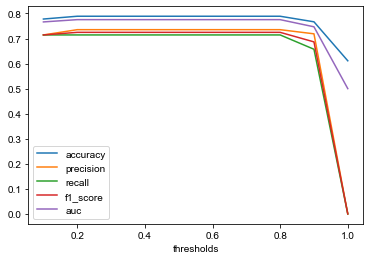

In [128]:
dtclf = DecisionTreeClassifier() # option : max_depth=4, ccp_alpha=0.01
dtclf.fit(X_train, y_train)
pred_proba = dtclf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba)

In [163]:
from sklearn.svm import SVC
from sklearn import metrics

svm_clf = SVC(kernel = 'rbf')
svm_clf.fit(X_train, y_train)
y_hat = svm_clf.predict(X_test)

svm_matrix = metrics.confusion_matrix(y_test, y_hat)
print(svm_matrix)

svm_report = metrics.classification_report(y_test, y_hat)
print(svm_report)

[[50  5]
 [25 10]]
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        55
           1       0.67      0.29      0.40        35

    accuracy                           0.67        90
   macro avg       0.67      0.60      0.58        90
weighted avg       0.67      0.67      0.63        90



In [201]:
print("VotingClassifier")
from sklearn.ensemble import VotingClassifier
voting_model = VotingClassifier(estimators=[('RandomForestClassifier', rnd_clf), ('BaggingClassifier', bag_clf),
                                            ('ExtraTreesClassifier', et_clf)], voting='soft', n_jobs=-1)
voting_model.fit(X_train, y_train)
voting_model_dt_pred = voting_model.predict(X_test)
get_clf_eval(y_test, voting_model_dt_pred)


print("\nRandomForestClassifier(n_estimators=10000, n_jobs=-1) ")
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10000, n_jobs=-1) 
rfc.fit(X_train, y_train)
rfc_dt_pred = rfc.predict(X_test)
get_clf_eval(y_test, rfc_dt_pred)

print("\nRandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, max_depth=5, criterion='entropy', max_features=None,)")
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, max_depth=5, 
                                 criterion='entropy', max_features=None,)
rnd_clf.fit(X_train, y_train)
rnd_clf_dt_pred = rnd_clf.predict(X_test)
get_clf_eval(y_test, rnd_clf_dt_pred)


print("\nExtraTreesClassifier")
from sklearn.ensemble import ExtraTreesClassifier
etsc = ExtraTreesClassifier()
etsc.fit(X_train, y_train)
etsc_dt_pred = etsc.predict(X_test)
get_clf_eval(y_test, etsc_dt_pred)


print("\nExtraTreesClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, max_depth=10, bootstrap=True, random_state=10, max_samples=1.0)")
from sklearn.ensemble import ExtraTreesClassifier
et_clf = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, max_depth=10, 
                              bootstrap=True, random_state=10, max_samples=1.0)
et_clf.fit(X_train, y_train)
et_clf_dt_pred = et_clf.predict(X_test)
get_clf_eval(y_test, et_clf_dt_pred)


print("\nDecisionTreeClassifier(max_depth=5)")
from sklearn.tree import DecisionTreeClassifier
dtclf = DecisionTreeClassifier(max_depth=5) 
dtclf.fit(X_train, y_train)
dtclf_dt_pred = dtclf.predict(X_test)
get_clf_eval(y_test, dtclf_dt_pred)

print("\nBaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=1000, max_samples=1.0, bootstrap=False, n_jobs=-1, bootstrap_features=True, max_features=0.5, oob_score=False)")
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=1000, 
                            max_samples=1.0, bootstrap=False, n_jobs=-1,
                            bootstrap_features=True, max_features=0.5, oob_score=False)
bag_clf.fit(X_train, y_train)
bag_clf_dt_pred = bag_clf.predict(X_test)
get_clf_eval(y_test, bag_clf_dt_pred)

print("\nDecisionTreeClassifier")
from sklearn.tree import DecisionTreeClassifier
dtclf = DecisionTreeClassifier() 
dtclf.fit(X_train, y_train)
dtclf_dt_pred = dtclf.predict(X_test)
get_clf_eval(y_test, dtclf_dt_pred)

print("\nExtraTreeClassifier")
from sklearn.tree import ExtraTreeClassifier
etc = ExtraTreeClassifier() 
etc.fit(X_train, y_train)
etc_dt_pred = etc.predict(X_test)
get_clf_eval(y_test, etc_dt_pred)

print("\nKNeighborsClassifier")
from sklearn.neighbors import KNeighborsClassifier 
kncf = KNeighborsClassifier()
kncf.fit(X_train, y_train)
kncf_dt_pred = kncf.predict(X_test)
get_clf_eval(y_test, kncf_dt_pred)

print("\nSVC")
from sklearn.svm import SVC 
svc = KNeighborsClassifier()
svc.fit(X_train, y_train)
svc_dt_pred = svc.predict(X_test)
get_clf_eval(y_test, svc_dt_pred)



VotingClassifier
-----
오차 행렬
 [[50  5]
 [11 24]]
정확도(accuracy) : 0.82
정밀도(precision) : 0.83
재현율(recall) : 0.69
f1 Score : 0.75
AUC : 0.80
-----

RandomForestClassifier(n_estimators=10000, n_jobs=-1) 
-----
오차 행렬
 [[49  6]
 [ 9 26]]
정확도(accuracy) : 0.83
정밀도(precision) : 0.81
재현율(recall) : 0.74
f1 Score : 0.78
AUC : 0.82
-----

RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, max_depth=5, criterion='entropy', max_features=None,)
-----
오차 행렬
 [[50  5]
 [10 25]]
정확도(accuracy) : 0.83
정밀도(precision) : 0.83
재현율(recall) : 0.71
f1 Score : 0.77
AUC : 0.81
-----

ExtraTreesClassifier
-----
오차 행렬
 [[48  7]
 [ 7 28]]
정확도(accuracy) : 0.84
정밀도(precision) : 0.80
재현율(recall) : 0.80
f1 Score : 0.80
AUC : 0.84
-----

ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, max_depth=10, bootstrap=True, random_state=10, max_samples=1.0)
-----
오차 행렬
 [[48  7]
 [ 9 26]]
정확도(accuracy) : 0.82
정밀도(precision) : 0.79
재현율(recall) : 0.74
f1 Score : 0.76
AUC : 0.81
-----

DecisionTreeC

(0.7333333333333333,
 0.6774193548387096,
 0.6,
 0.6363636363636364,
 0.7090909090909091)

In [196]:
from sklearn.ensemble import ExtraTreesClassifier
etsc = ExtraTreesClassifier()
etsc.fit(X, y)
etsc_dt_pred = etsc.predict(df_test)
df_test['survived'] = etsc_dt_pred

# 파일 저장
tit = pd.read_csv('./test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True)
tit['Survived'] = df_test['survived']
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test_etsc.csv')

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, max_depth=5, 
                                 criterion='entropy', max_features=None,)
et_clf = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, max_depth=10, 
                              bootstrap=True, random_state=10, max_samples=1.0)
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=1000, 
                            max_samples=1.0, bootstrap=False, n_jobs=-1,
                            bootstrap_features=True, max_features=0.5, oob_score=False)
voting_model = VotingClassifier(estimators=[('RandomForestClassifier', rnd_clf), ('BaggingClassifier', bag_clf),
                                            ('ExtraTreesClassifier', et_clf)], voting='soft', n_jobs=-1)

In [208]:
# voting kaggle
from sklearn.ensemble import VotingClassifier
voting_model = VotingClassifier(estimators=[('RandomForestClassifier', rnd_clf), ('BaggingClassifier', bag_clf),
                                            ('ExtraTreesClassifier', et_clf)], voting='soft', n_jobs=-1)
voting_model.fit(X, y)
voting_model_dt_pred = voting_model.predict(df_test)
df_test['survived'] = voting_model_dt_pred

# 파일 저장
tit = pd.read_csv('./test.csv')
tit.drop(list(tit.columns)[1:], axis = 1, inplace=True)
tit['Survived'] = df_test['survived']
tit.set_index('PassengerId', inplace=True)
tit.to_csv('tit_test_voting.csv')

In [193]:
df_test

,Pclass,Sex,Age,Fare,age_new,family,survived
0,3,1,34.500000,7.8292,2,0,0
1,3,0,47.000000,7.0000,2,1,0
2,2,1,62.000000,9.6875,1,0,1
3,3,1,27.000000,8.6625,2,0,0
4,3,0,22.000000,12.2875,2,2,1
...,...,...,...,...,...,...,...
413,3,1,24.525104,8.0500,2,0,0
414,1,0,39.000000,108.9000,2,0,1
415,3,1,38.500000,7.2500,2,0,0
416,3,1,24.525104,8.0500,2,0,0


In [236]:
'''
GBM은 경사 하강법(Gradient Descent)를 이용해 가중치 업데이트를 수행하는 기법이다. 
GBM이 일반적으로 랜덤포레스트보다 성능이 뛰어나기는 하지만, 수행 시간이 오래 걸린다는 단점이 있다.

loss : 경사 하강법에서 사용할 비용함수 지정 (디폴트는 deviance)
learning_rate : 약한 학습기가 순차적으로 오류 값을 보정해 나가는 데 적용하는 계수로 0 ~ 1 값 지정 가능 (디폴트는 0.1)
너무 작은 값 지정 -> 예측 성능은 높아질 수 있지만 수행 시간이 오래 걸릴 수 있고, 반복이 완료되어도 최소오류값을 찾지 못할 수 있음
너무 큰 값 지정 -> 빠른 수행은 가능하지만 최소오류값을 못찾고 지나쳐 예측 성능이 저하될 수 있음
n_estimators : 약한 학습기의 개수 (디폴트는 100)
개수가 많을수록 예측 성능은 높아질 수 있지만 수행 시간이 오래 걸림
subsample : 학습에 사용하는 데이터의 샘플링 비율로 0 ~ 1 값 지정 가능 (디폴트는 1, 즉 전체 학습 데이터 기반)
'''

print("GradientBoostingClassifier")
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_dt_pred = gbc.predict(X_test)
get_clf_eval(y_test, gbc_dt_pred)

from sklearn.model_selection import GridSearchCV
params = {'n_estimators' : [i for i in range(100, 200)], 'learning_rate' : [i * 0.01 for i in range(5, 10)]}
grid_cv = GridSearchCV(gbc, param_grid=params)
grid_cv.fit(X_train, y_train)
gcv = grid_cv.best_params_
print('\n최적 하이퍼 파라미터:\n', gcv)
print('최고 예측 정확도: {0:.4f}\n'.format(grid_cv.best_score_))

new_pred = grid_cv.best_estimator_.predict(X_test)
get_clf_eval(y_test, new_pred)


GradientBoostingClassifier
-----
오차 행렬
 [[49  6]
 [10 25]]
정확도(accuracy) : 0.82
정밀도(precision) : 0.81
재현율(recall) : 0.71
f1 Score : 0.76
AUC : 0.80
-----

최적 하이퍼 파라미터:
 {'learning_rate': 0.09, 'n_estimators': 131}
최고 예측 정확도: 0.8390

-----
오차 행렬
 [[49  6]
 [10 25]]
정확도(accuracy) : 0.82
정밀도(precision) : 0.81
재현율(recall) : 0.71
f1 Score : 0.76
AUC : 0.80
-----


(0.8222222222222222,
 0.8064516129032258,
 0.7142857142857143,
 0.7575757575757576,
 0.8025974025974026)

In [12]:
param = {'ccp_alpha': 0.011001332269966666,
         'learning_rate': 0.1,
         'loss': 'exponential',
         'max_depth': 8,
         'max_features': 'log2',
         'min_impurity_decrease': 0.8671820004771132,
         'min_samples_leaf': 28,
         'min_samples_split': 0.32582763423323347,
         'n_estimators': 300}

gbc = GradientBoostingClassifier(**param)
gbc.fit(X_train, y_train)
gbc_dt_pred = gbc.predict(X_test)
get_clf_eval(y_test, gbc_dt_pred)

-----
오차 행렬
 [[57  2]
 [10 21]]
정확도(accuracy) : 0.87
정밀도(precision) : 0.91
재현율(recall) : 0.68
f1 Score : 0.78
AUC : 0.82
-----


(0.8666666666666667,
 0.9130434782608695,
 0.6774193548387096,
 0.7777777777777777,
 0.8217605248769819)

In [250]:
gbm_clf = GradientBoostingClassifier()

gbm_results = cross_val_score(gbm_clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=4)
print('gbm 교차검증:', round(np.mean(gbm_results), 3))

gbm_clf.fit(X_train, y_train)
print('gbm 예측점수:', round(np.mean(gbm_clf.score(X_test, y_test)), 3))

gbm 교차검증: 0.818
gbm 예측점수: 0.9


In [8]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

def gbm_objective(search_space):
    model = GradientBoostingClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'loss':hp.choice('loss', ['deviance', 'exponential']),
              'max_depth':hp.choice('max_depth', range(2, 10)),
              'min_samples_split':hp.uniform('min_samples_split', 0.1, 1),
              'min_samples_leaf':hp.choice('min_samples_leaf', range(1, 30)),
              'max_features':hp.choice('max_features', [None, 'sqrt', 'log2']),
              'min_impurity_decrease':hp.uniform('min_impurity_decrease', 0.1, 1),
              'ccp_alpha':hp.uniform('ccp_alpha', 0.01, 1),
              'learning_rate':hp.choice('learning_rate', [0.1, 0.01]),
              'n_estimators':hp.choice('n_estimators', [100, 200, 300, 400, 500,1000])}

# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=gbm_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

100%|██████| 500/500 [01:47<00:00,  4.67trial/s, best loss: -0.8777777777777778]


In [14]:
best_gbm_clf = GradientBoostingClassifier(**params1)
best_gbm_clf.fit(X_train, y_train)
best_gbm_clf_pred = best_gbm_clf.predict(df_test)
get_clf_eval(y_test, best_gbm_clf_pred)

-----


ValueError: Found input variables with inconsistent numbers of samples: [90, 418]

In [ ]:
best_gbm_clf.fit(X_train, y_train)
kg_upload = df_kg.copy()
kg_upload['Survived'] = best_gbm_clf.predict(df_kg)
kg_upload.Survived.to_csv('./kaggle_upload_boosting2.csv')

In [254]:
#
conda install -c anaconda py-xgboost

Solving environment: done

## Package Plan ##

  environment location: /Users/werther/opt/anaconda3

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  anaconda
    ca-certificates-2022.4.26  |       hecd8cb5_0         132 KB  anaconda
    certifi-2022.6.15          |   py39hecd8cb5_0         157 KB  anaconda
    libxgboost-1.5.0           |       he9d5cce_1         2.2 MB  anaconda
    openssl-1.1.1o             |       hca72f7f_0         3.5 MB  anaconda
    py-xgboost-1.5.0           |   py39hecd8cb5_1         164 KB  anaconda
    ------------------------------------------------------------
                                           Total:         6.2 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  anaconda/osx-64::_py-xgboost-mutex-2.0-cpu_0 None
  libxgboost

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import xgboost as xgb

In [21]:
from xgboost import XGBClassifier

In [31]:
print("XGBClassifier")
xgb = XGBClassifier(**params1)
xgb.fit(X_train, y_train)
xgb_dt_pred = xgb.predict(X_test)
get_clf_eval(y_test, xgb_dt_pred)

XGBClassifier
[17:52:13] WARNING: ../src/learner.cc:576: 
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:52:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----
오차 행렬
 [[57  2]
 [ 7 24]]
정확도(accuracy) : 0.90
정밀도(precision) : 0.92
재현율(recall) : 0.77
f1 Score : 0.84
AUC : 0.87
-----


(0.9,
 0.9230769230769231,
 0.7741935483870968,
 0.8421052631578947,
 0.8701476216511754)

In [30]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

def gbm_objective(search_space):
    model = XGBClassifier(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# new search space
search_space={'loss':hp.choice('loss', ['deviance', 'exponential']),
              'max_depth':hp.choice('max_depth', range(2, 10)),
              'min_samples_split':hp.uniform('min_samples_split', 0.1, 1),
              'min_samples_leaf':hp.choice('min_samples_leaf', range(1, 30)),
              'max_features':hp.choice('max_features', [None, 'sqrt', 'log2']),
              'min_impurity_decrease':hp.uniform('min_impurity_decrease', 0.1, 1),
              'ccp_alpha':hp.uniform('ccp_alpha', 0.01, 1),
              'learning_rate':hp.choice('learning_rate', [0.1, 0.01]),
              'n_estimators':hp.choice('n_estimators', [100, 200, 300, 400, 500,1000])}

# set the hyperparam tuning algorithm
algorithm=tpe.suggest
# implement Hyperopt
best_params = fmin(fn=gbm_objective,
                   space=search_space,
                   algo=algorithm,
                   max_evals=500)

params1 = space_eval(search_space, best_params)

[17:48:03] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:04] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:48:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:07] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:07] WARNING: ../sr

[17:48:11] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:12] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:48:17] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:18] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:48:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:22] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:22

[17:48:26] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:27] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[17:48:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:31] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:31] WARNING: ../sr

[17:48:36] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:36] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[17:48:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:41] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:41] WARNING: ../sr

[17:48:46] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:47] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:48:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:50] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:51

[17:48:55] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:48:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:55] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:49:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:01] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:01] WARNING: ../sr

[17:49:05] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:06] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[17:49:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:10] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:11

[17:49:15] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:15] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[17:49:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:21] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:21

[17:49:25] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:26] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[17:49:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:31] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:31] WARNING: ../sr

[17:49:35] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:35] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[17:49:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:40] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:41] WARNING: ../sr

[17:49:45] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:45] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:49:50] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:51] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[17:49:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:56] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:49:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:57] WARNING: ../sr

[17:50:01] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:01] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:50:06] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:06] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:50:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:10] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:11

[17:50:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:16] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:17

[17:50:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:21] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:21

[17:50:26] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:26] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[17:50:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:32] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:32] WARNING: ../sr

[17:50:36] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:37] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:50:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:42] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:42] WARNING: ../sr

[17:50:46] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:46] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters gettin

[17:50:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:51] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:51] WARNING: ../sr

[17:50:54] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:50:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:55] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:51:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:00] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:01] WARNING: ../sr

[17:51:05] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:05] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[17:51:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:09] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:09

[17:51:15] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:16] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:51:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:21] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:21

[17:51:24] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:25] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some p

[17:51:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:30] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:30

[17:51:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:36] WARNING: ../src/learner.cc:576:                                      
Parameters: { "ccp_alpha", "loss", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:36